In [1]:
import pandas as pd
%load_ext autotime

from gscore.parsers.osw import OSWFile
from gscore.parsers.queries import SelectPeakGroups
from gscore.parsers.sqmass import SqMassFile
from gscore.models.deep_chromatogram_classifier import DeepChromScorer

time: 1.51 s (started: 2022-02-22 14:11:47 +01:00)


In [2]:
sqmass_file_path = "/home/aaron/projects/ghost/data/spike_in/chromatograms/AAS_P2009_167.sqMass"
osw_file_path = "/home/aaron/projects/ghost/data/spike_in/openswath/AAS_P2009_167.osw"

time: 937 µs (started: 2022-02-22 14:11:49 +01:00)


In [3]:
osw_file = OSWFile(
    osw_file_path,
    set_indices=True
)
precursors = osw_file.parse_to_precursors(
    query=SelectPeakGroups.FETCH_PREC_RECORDS
)

time: 7.59 s (started: 2022-02-22 14:11:50 +01:00)


In [4]:
precursors.denoise(
    num_folds=10,
    num_classifiers=10,
    num_threads=10,
    vote_percentage=10,
)

Mean recall: 0.6491377302182427, Mean precision: 0.8865739845260474


time: 21.3 s (started: 2022-02-22 14:11:58 +01:00)


In [5]:
chromatogram_file = SqMassFile(sqmass_file_path)

chromatograms = chromatogram_file.parse()

precursors.set_chromatograms(chromatograms)

time: 29.6 s (started: 2022-02-22 14:12:19 +01:00)


In [6]:
positive_labels = precursors.filter_target_peakgroups(
    rank=1, filter_key="VOTE_PERCENTAGE", value=0.0
)

time: 68.3 ms (started: 2022-02-22 14:12:49 +01:00)


In [7]:
negative_labels= precursors.get_decoy_peakgroups(
    use_second_ranked=False
)

time: 60.4 ms (started: 2022-02-22 14:12:49 +01:00)


In [8]:
from gscore import preprocess

combined = positive_labels + negative_labels

(
    all_data_labels,
    all_data_indices,
    all_chromatograms,
    all_scores
) = preprocess.reformat_chromatogram_data(
    combined,
    use_relative_intensities=True
)

Reformat
[WARNING] 71 peakgroups with no found chromatograms found.
time: 1.9 s (started: 2022-02-22 14:12:49 +01:00)


In [9]:
all_scores.shape

(49062, 23)

time: 1.54 ms (started: 2022-02-22 14:12:54 +01:00)


In [10]:
scoring_model = DeepChromScorer(
    max_epochs=1,
    gpus=1,
    threads=10
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


time: 2.12 s (started: 2022-02-22 14:12:56 +01:00)


In [24]:
scoring_model.load(
    "/home/aaron/projects/ghost/data/spike_in/test-embedding.model"
)

time: 197 ms (started: 2022-02-22 14:26:28 +01:00)


In [44]:
chromatogram_embeddings = scoring_model.encode(
    all_chromatograms
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

time: 3.37 s (started: 2022-02-22 14:31:08 +01:00)


In [45]:
chromatogram_embeddings.max(), chromatogram_embeddings.min()

(35.28483200073242, -42.34419250488281)

time: 3.63 ms (started: 2022-02-22 14:31:12 +01:00)


In [46]:
import numpy as np

chromatogram_embeddings.max(), chromatogram_embeddings.min(), np.isnan(chromatogram_embeddings).any()

(35.28483200073242, -42.34419250488281, False)

time: 4.96 ms (started: 2022-02-22 14:31:13 +01:00)


In [47]:
from gscore.scorer import XGBoostScorer
from gscore.scaler import Scaler
from sklearn.model_selection import train_test_split  # type: ignore
from sklearn.utils import class_weight  # type: ignore
from gscore import preprocess

from sklearn.metrics import recall_score, precision_score

import seaborn as sns

time: 509 µs (started: 2022-02-22 14:31:13 +01:00)


In [48]:
from collections import Counter

training_data = np.concatenate(
    (all_scores, chromatogram_embeddings),
    axis=1
)

scaler = Scaler()

training_data, testing_data, training_labels, testing_labels = train_test_split(
    training_data, all_data_labels,
    test_size=0.2,
    shuffle=True
)
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(training_labels),
    y=training_labels.ravel(),
)

counter: Counter = Counter(training_labels.ravel())
scale_pos_weight = counter[0] / counter[1]

print(scale_pos_weight)

scorer = XGBoostScorer(scale_pos_weight=scale_pos_weight)

training_data = scaler.fit_transform(training_data)

scorer.fit(training_data, training_labels.ravel())

testing_data = scaler.transform(testing_data)

print("Evaluating model...")

roc = scorer.evaluate(testing_data, testing_labels)

print(f"Model ROC-AUC: {roc}")
recall = recall_score(
    y_true=testing_labels.ravel(),
    y_pred=scorer.model.predict(testing_data)
)

precision = precision_score(
    y_true=testing_labels.ravel(),
    y_pred=scorer.model.predict(testing_data)
)

print(f"Model Precision: {precision}")
print(f"Model Recall: {recall}")

0.5899295147046909


/home/aaron/miniconda3/envs/ghostdev/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:31:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Evaluating model...
Model ROC-AUC: 0.8287469415736718
Model Precision: 0.908256880733945
Model Recall: 0.6752192270217603
time: 8.32 s (started: 2022-02-22 14:31:14 +01:00)


<AxesSubplot:xlabel='scores', ylabel='Count'>

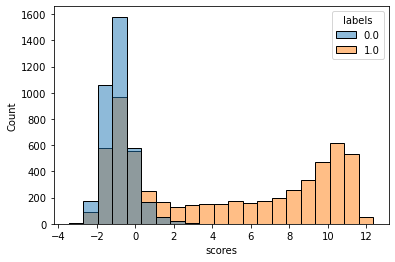

time: 165 ms (started: 2022-02-22 14:31:23 +01:00)


In [49]:
score_df = pd.DataFrame(
    {
        "labels": testing_labels.ravel(),
        "scores": scorer.score(testing_data)
    }
)

sns.histplot(
    score_df,
    x="scores",
    hue="labels"
)

In [50]:
from collections import Counter

scaler = Scaler()

training_data, testing_data, training_labels, testing_labels = train_test_split(
    all_scores, all_data_labels,
    test_size=0.2,
    shuffle=True
)
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(training_labels),
    y=training_labels.ravel(),
)

counter: Counter = Counter(training_labels.ravel())
scale_pos_weight = counter[0] / counter[1]

print(scale_pos_weight)

scorer = XGBoostScorer(scale_pos_weight=scale_pos_weight)

training_data = scaler.fit_transform(training_data)

scorer.fit(training_data, training_labels.ravel())

testing_data = scaler.transform(testing_data)

print("Evaluating model...")

roc = scorer.evaluate(testing_data, testing_labels)

print(f"Model ROC-AUC: {roc}")

recall = recall_score(
    y_true=testing_labels.ravel(),
    y_pred=scorer.model.predict(testing_data)
)

precision = precision_score(
    y_true=testing_labels.ravel(),
    y_pred=scorer.model.predict(testing_data)
)

print(f"Model Precision: {precision}")
print(f"Model Recall: {recall}")

0.5934150698278662
[14:31:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/aaron/miniconda3/envs/ghostdev/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Evaluating model...
Model ROC-AUC: 0.8240966280204415
Model Precision: 0.9042437431991295
Model Recall: 0.6688667095943336
time: 2.79 s (started: 2022-02-22 14:31:48 +01:00)


<AxesSubplot:xlabel='scores', ylabel='Count'>

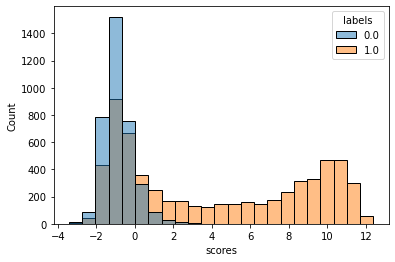

time: 187 ms (started: 2022-02-22 14:31:51 +01:00)


In [51]:
score_df = pd.DataFrame(
    {
        "labels": testing_labels.ravel(),
        "scores": scorer.score(testing_data)
    }
)

sns.histplot(
    score_df,
    x="scores",
    hue="labels"
)